# Third Laboratory
### Group "Trap" - Data Science for Business 2022

Oh no! My attempt on analyzing the impact COVID had on the job market failed miserably :(

Some alien ate part of my data, and now it's gone for good! For some reason this creature divoured all the record after the 12th day of each month. What a strange (and cruel) creature!

![](./res/pacman.png)

I'm now left with an incomplete dataset, so my question now is: **will it be enough to produce good predictions?**

Luckily I found, on another source, a complete dataset that the beast was not able to find... yet. I will use this one to compare the prediction results although it has some problems:

* The data is aggregated by trimester, so not much data points
* The period is limited to 2016-2021, while the original one had a good amount of data from 2009. Even fewer data points!

### Am I doomed? Probably I am.

# Let's start!

In [60]:
data_path = "~/data/"

import pandas as pd
import math

## Loading *incomplete* dataset

Here we load the incomplete dataset and rework it to make it similar to the complete one we found:

- Aggregated by trimester
- With macro-cateogories for GENERE and PROVINCIAIMPRESA and nothing else

In [83]:
def prepare_dataset(path): 
    ds = pd.read_csv(path)
    ds["DATA"] = pd.to_datetime(ds["DATA"], dayfirst=True, errors="coerce")
    ds = ds.sort_values("DATA", ignore_index=True)
        
    # From previous labs we already know there is one record with invalid date, 
    # let's remove it
    ds = ds[ds['DATA'].notna()]
    
    # Creating column MESE e ANNO
    ds['MESE'] = ds['DATA'].dt.month
    ds['ANNO'] = ds['DATA'].dt.year
    
    # Create column TRIM so that data is divided in trimesters
    ds['TRIM'] = ds['MESE'].apply(lambda x : math.ceil(x/3))
    
    # Let's remove the columns we're not interested in
    ds.drop(['ETA', 
             'TITOLOSTUDIO',
             'SETTOREECONOMICODETTAGLIO', 
             'CONTRATTO', 
             'MODALITALAVORO',
             'ITALIANO',
             'DATA', 
             'MESE'], axis=1, inplace=True)
    
    trims = [(x, y, z) for x in range(2008, 2022) for y in range(1, 5) for z in ['M', 'F']]
    return ds.groupby(["ANNO", "TRIM", "GENERE"]).size().reindex(trims)

jobs = prepare_dataset(data_path + "Rapporti_di_lavoro_attivati.csv")
ceased = prepare_dataset(data_path + "Rapporti_di_lavoro_cessati.csv")

## Loading *complete* dataset

Here we load the dataset we found [here](https://quadrantelavoro.regione.lombardia.it/pentaho/content/pentaho-cdf-dd/Render?solution=dasLombardia&path=%2FcruscottoComObb&file=com_obb_genere.wcdf&anno_i=undefined&anno_f=2020&territorio=Regione).


In [79]:
def prepare_dataset(path): 
    ds = pd.read_csv(path, sep=';')
    
    # Create column ANNO
    ds['ANNO'] = ds['Trimestre'].apply(lambda x: int(x[-4:]))
    
    # Create column TRIM so that data is divided in trimesters
    def trimester(x):
        if x[0:5] == 'Primo':
            return 1
        elif x[0:7] == 'Secondo':
            return 2
        elif x[0:5] == 'Terzo':
            return 3
        else:
            return 4
    
    ds['TRIM'] = ds['Trimestre'].apply(trimester)
    
    # Fix GENERE
    ds['Genere'] = ds['Genere'].apply(lambda x: 'F' if x == 'Femmina' else 'M')
    
    # Let's remove the columns we're not interested in
    ds.drop(['Trimestre', 'ModalitaLavoro'], axis=1, inplace=True)
    
    # Fix column names
    ds.rename(str.upper, axis='columns', inplace=True)
    
    # Groupby and reindex
    trims = [(x, y, z) for x in range(2008, 2022) for y in range(1, 5) for z in ['M', 'F']]
    return ds.groupby(["ANNO", "TRIM", "GENERE"]).sum().reindex(trims)

q_jobs = prepare_dataset(data_path + "Quadrante_avviamenti.csv")
q_ceased = prepare_dataset(data_path + "Quadrante_cessazioni.csv")

## Joining into a single DataFrame

In [93]:
jmarket = pd.concat([jobs, ceased, q_jobs, q_ceased], axis=1).rename(columns={
               0: "inc_jobs", 
               1: "inc_ceased", 
               "AVVIAMENTI": "real_jobs", 
               "CESSAZIONI": "real_ceased"})

jmarket

inc_jobs  inc_ceased  real_jobs  real_ceased
ANNO TRIM GENERE                                              
2008 1    M             63         117        NaN          NaN
          F            464         620        NaN          NaN
     2    M             40          96        NaN          NaN
          F            266         487        NaN          NaN
     3    M             61         111        NaN          NaN
...                    ...         ...        ...          ...
2021 2    F          64818       26349   166128.0     179251.0
     3    M          90831       27022   237961.0     226690.0
          F          71907       19755   216087.0     190358.0
     4    M          85337       26346   238128.0     264854.0
          F          73340       18691   209248.0     212175.0

[112 rows x 4 columns]

#### Save new dataset

In [148]:
#jmarket.to_csv(data_path + "jmarket.csv")
jmarket = pd.read_csv(data_path + "jmarket.csv", index_col=[0, 1, 2])

### So, here's the situation...

In [149]:
jmarket = jmarket.loc[2016:].groupby(['ANNO', 'TRIM']).sum()

<AxesSubplot:xlabel='ANNO,TRIM'>

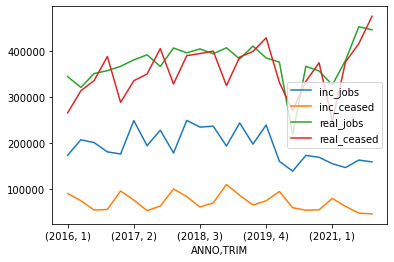

In [150]:
jmarket.plot()

<AxesSubplot:xlabel='ANNO,TRIM'>

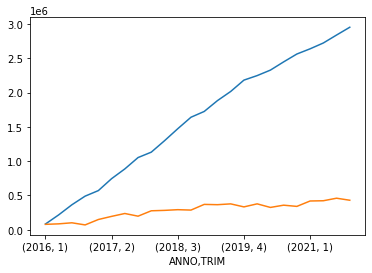

In [152]:
(jmarket['inc_jobs']-jmarket['inc_ceased']).cumsum().plot()
(jmarket['real_jobs']-jmarket['real_ceased']).cumsum().plot()

## Studying correlations

Let's check if we can use an incomplete time series to predict the complete one.

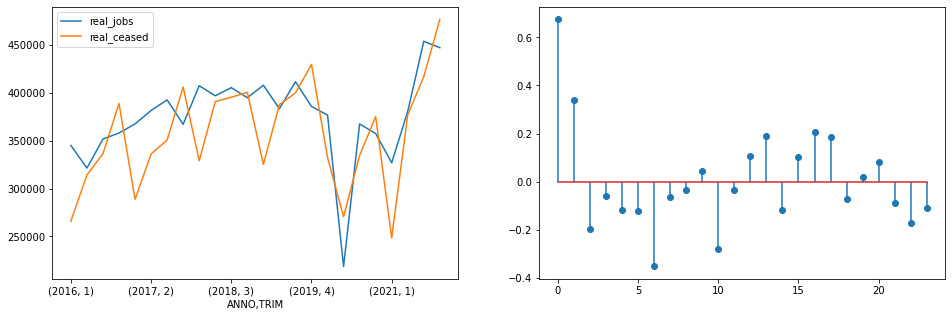

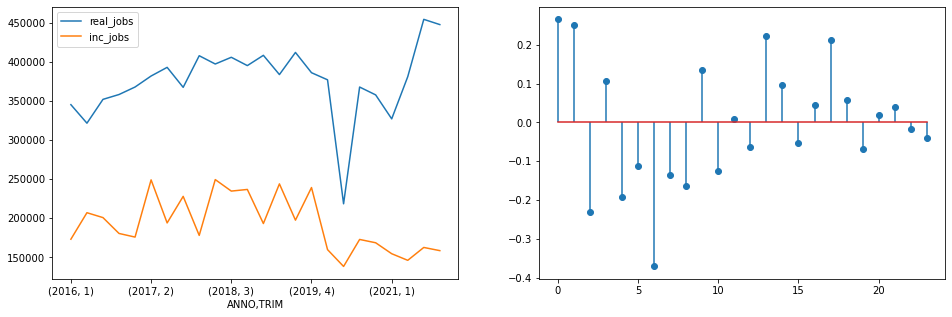

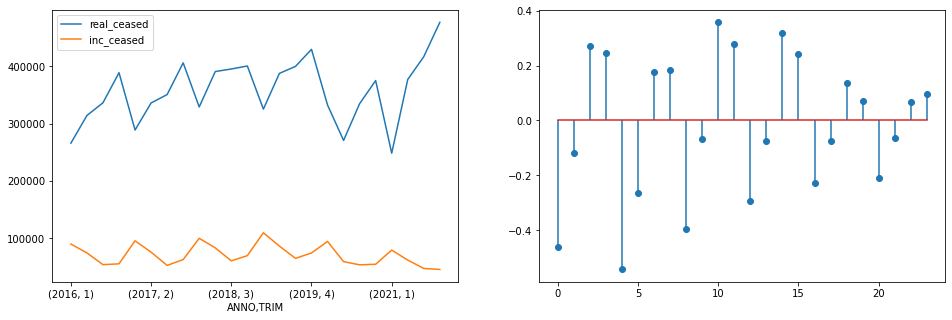

In [208]:
import statsmodels.api as sm

def corr(ds, key1, key2):
    plt.figure(figsize=(16,5))
    plt.subplot(1,2,1)
    ds[[key1, key2]].plot(ax=plt.gca())
    plt.subplot(1,2,2)
    plt.stem(sm.tsa.stattools.ccf(ds[key1], ds[key2], adjusted=False))
    plt.show()
        
corr(jmarket, 'real_jobs', 'real_ceased')
corr(jmarket, 'real_jobs', 'inc_jobs')
corr(jmarket, 'real_ceased', 'inc_ceased')
plt.show()

## Results

While _real_jobs_ and _real_ceased_ have a somewhat good (zero lag) cross-correlation (about 0.7), we can't say the same about _real_jobs_ with _inc_jobs_ and _real_ceased_ with _inc_ceased_, meaning that those incomplete dataset can't be used to do meaningful predictions.

## What now?

We have _real_jobs_ and _real_ceased_ which have 24 data points each (16 if we consider the pre-covid period).

We define a new dataset, _jobs_balance_, which is obtained by subtracting _real_ceased_ from _real_jobs_, obtaining the net jobs balance for each trimester, then computing a cumulative sum, so that for each data point we have the total net jobs since 2016-Q1.

# Analyzing the cumulative jobs balance

In [371]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from dateutil.parser import parse
from pandas.plotting import autocorrelation_plot

def seas_dec(ts):
    # Multiplicative Decomposition 
    result_mul = seasonal_decompose(ts, model='multiplicative', extrapolate_trend='freq')

    # Additive Decomposition
    result_add = seasonal_decompose(ts, model='additive', extrapolate_trend='freq')

    # Plot
    plt.rcParams.update({'figure.figsize': (10,10)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=18)
    result_add.plot().suptitle('Additive Decompose', fontsize=18)
    plt.show()


    
    
def extract_serie(ds, key):
    serie = ds[key].reset_index()
    serie["DATA"] = serie["ANNO"].astype(str) + "/" + (3*serie["TRIM"]).astype(str) + "/01"
    serie["DATA"] = pd.to_datetime(serie["DATA"])
    return serie.set_index("DATA")[key]

/home/mirko/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


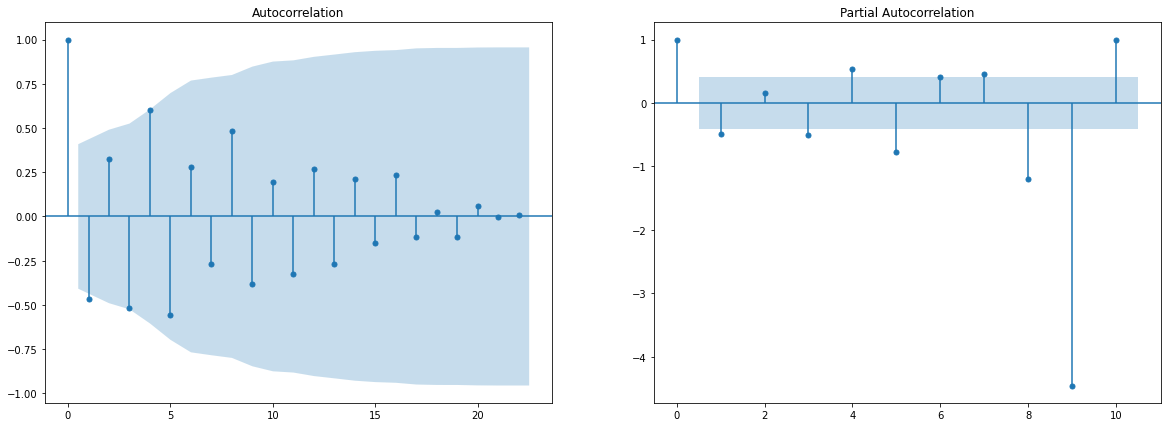

In [430]:
jobs_balance = (extract_serie(jmarket, "real_jobs") - extract_serie(jmarket, "real_ceased")).cumsum()

fig,ax = plt.subplots(1,2,figsize=(20,7))
plot_acf(jobs_balance.diff().dropna(), lags=22, ax=ax[0])
plot_pacf(jobs_balance.diff().dropna(), lags=10, ax=ax[1])
plt.show()

In [419]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(jobs_balance.diff().dropna())
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: -1.112006
p-value: 0.710260


### First impression

The series has to few values to have take make precise statements about it, but it does appear to be seasonal.

## Trying SARIMA

Let's see what we get by using _auto_arima_ to get parameters and then SARIMA to make a 2020-2021 prediction with 2016-2019 data, then we will compare with the actual 2020-2021 data.

In [342]:
from pmdarima.arima import auto_arima

jobs_balance_nocovid = jobs_balance[:'2020-01-01']

# Train/Test split
ts = jobs_balance_nocovid
train_size = 0.75
split_idx = round(len(ts)* train_size)
# Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

model = auto_arima(train,
                      start_p=0,
                      start_q=0,
                      information_criterion='aic',
                      test='adf',
                      max_p=4,
                      max_q=4,
                      D=1,
                      start_P=0,
                      m = 4,
                      seasonal=True,
                      trace=True,
                      error_action="ignore",
                      suppress_warnings=True,
                      stepwise=True,
                      verbose=1)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,1)[4]             : AIC=145.969, Time=0.01 sec
 ARIMA(0,2,0)(0,1,0)[4]             : AIC=144.756, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[4]             : AIC=147.826, Time=0.02 sec
 ARIMA(0,2,1)(0,1,1)[4]             : AIC=148.339, Time=0.02 sec
 ARIMA(0,2,0)(1,1,0)[4]             : AIC=145.828, Time=0.04 sec
 ARIMA(0,2,0)(1,1,1)[4]             : AIC=147.834, Time=0.02 sec
 ARIMA(1,2,0)(0,1,0)[4]             : AIC=146.532, Time=0.01 sec
 ARIMA(0,2,1)(0,1,0)[4]             : AIC=146.733, Time=0.01 sec
 ARIMA(1,2,1)(0,1,0)[4]             : AIC=149.465, Time=0.02 sec
 ARIMA(0,2,0)(0,1,0)[4] intercept   : AIC=146.480, Time=0.00 sec

Best model:  ARIMA(0,2,0)(0,1,0)[4]          
Total fit time: 0.182 seconds


/home/mirko/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   12
Model:             SARIMAX(0, 2, 0)x(0, 1, 0, 4)   Log Likelihood                 -71.378
Date:                           Fri, 20 May 2022   AIC                            144.756
Time:                                   16:56:11   BIC                            144.548
Sample:                                        0   HQIC                           143.923
                                            - 12                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.039e+08   4.43e+08      2.039      0.041    3.51e+07    1.77e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.63
Prob(Q):                              1.00   Prob(JB):                         0.73
Heteroskedasticity (H):               3.22   Skew:                             0.77
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [424]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model2 = SARIMAX(jobs_balance_nocovid, order=(0,1,0), seasonal_order=(0,1,0,4))
results = model2.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99564D+00    |proj g|=  1.44191D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      7      1     0     0   3.314D-06   7.970D+00
  F =   7.9704504986306377     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/mirko/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
/home/mirko/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


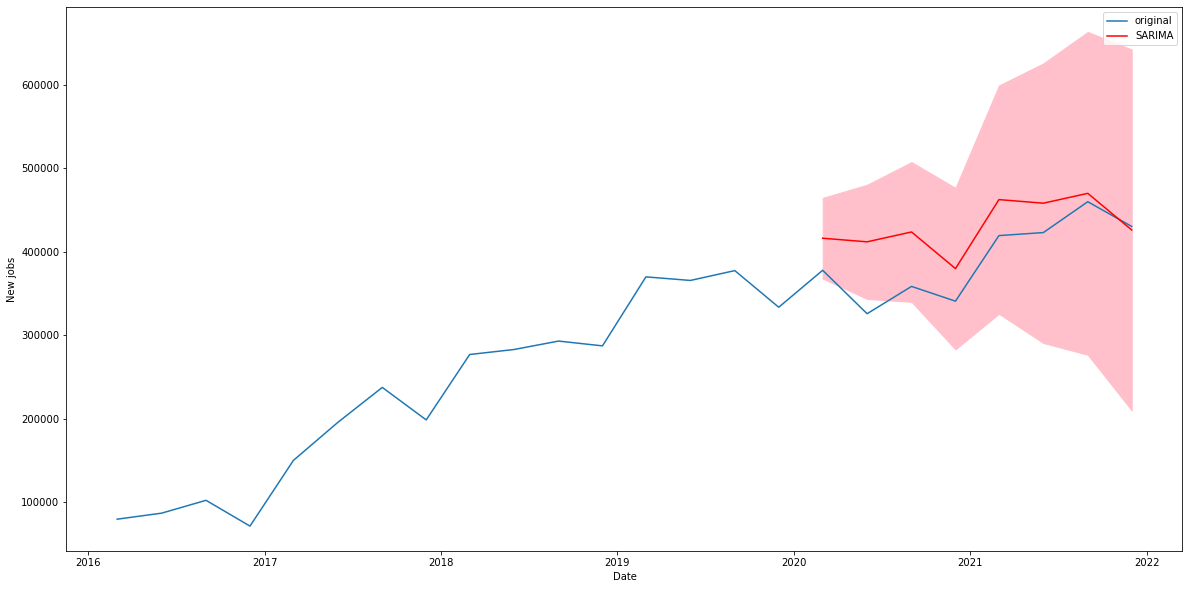

In [444]:
# Create ARIMA mean forecast
forecast = results.get_forecast(steps=8)
lower = forecast.conf_int()["lower y"]
upper = forecast.conf_int()["upper y"]

# Plot mean ARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(jobs_balance, label='original')
plt.plot(forecast.predicted_mean, label='SARIMA', c="r")
plt.fill_between(forecast.conf_int().index, 
                 lower,upper,
                 color='pink')
plt.xlabel('Date')
plt.ylabel('New jobs')
plt.legend()
plt.show()

### Result

According to the forecast, it does seem that initialy COVID has potentially slowed down the growth of the job market for a few months, but after the initial emergency the actual job market catched up with the predictions.